In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [5]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

- plot

In [6]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [7]:
def choose_plot_grid(n:int,r_max=8,c_max=17):
    rs = np.sqrt(n)
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where(res==np.min(res))
    #TODO : if len(min_idx) > 1 : minimize abs(sppt-col_nums), col_nums
    return sppt[min_idx[0]], col_nums[min_idx[0]]


def plot_feat_hue(data:pd.DataFrame,hue_label_dict=None):
    num_r, num_c = choose_plot_grid(len(data))
    fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=True,sharey=True)
    for n,ax in enumerate(axes.flatten()):
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        sns.barplot(x=data.iloc[n].index, y = data.iloc[n].values,ax =ax)
        feat_name = data.index[n]
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)

    pass

## LOAD DATA

In [8]:
pvtb_name = 'pvtb_city_entire_ver0.csv'


pvtb_path = os.path.join(pvtb_dir,pvtb_name)
pvtb_entire = pd.read_csv(pvtb_path)

pvtb_entire

geo_label_city  date_label strata_race_label strata_sex_label  \
0            Austin        2010               All             Both   
1            Austin        2010               All           Female   
2            Austin        2010               All             Male   
3            Austin        2010          Asian/PI             Both   
4            Austin        2010          Asian/PI           Female   
...             ...         ...               ...              ...   
7275     Washington        2022          Hispanic             Male   
7276     Washington        2022           Natives             Both   
7277     Washington        2022             White             Both   
7278     Washington        2022             White           Female   
7279     Washington        2022             White             Male   

      Active Transportation | Riding Bike to Work  \
0                                        1.458997   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   
...                                           ...   
7275                                          NaN   
7276                                          NaN   
7277                                          NaN   
7278                                          NaN   
7279                                          NaN   

      Active Transportation | Walking to Work  \
0                                    2.506039   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
...                                       ...   
7275                                      NaN   
7276                                 8.766234   
7277                                14.201808   
7278                                      NaN   
7279                                      NaN   

      Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
0                                  2.191781                         25.479452   
1                                       NaN                               NaN   
2                                       NaN                               NaN   
3                                       NaN                               NaN   
4                                       NaN                               NaN   
...                                     ...                               ...   
7275                                    NaN                               NaN   
7276                                    NaN                               NaN   
7277                                    NaN                               NaN   
7278                                    NaN                               NaN   
7279                                    NaN                               NaN   

      Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
0                                    NaN                  7.836414  ...   
1                                    NaN                       NaN  ...   
2                                    NaN                       NaN  ...   
3                                    NaN                  8.785406  ...   
4                                    NaN                       NaN  ...   
...                                  ...                       ...  ...   
7275                                 NaN                       NaN  ...   
7276                                 NaN                       NaN  ...   
7277                                 NaN                  5.574537  ...   
7278                                 NaN                       NaN  ...   
7279                                 NaN                       NaN  ...   

      Substance Use | Adult Smoking  Substance Use | Drug Overdo

<Axes: >

/home/doeun/anaconda3/envs/EST_NA/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/doeun/anaconda3/envs/EST_NA/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


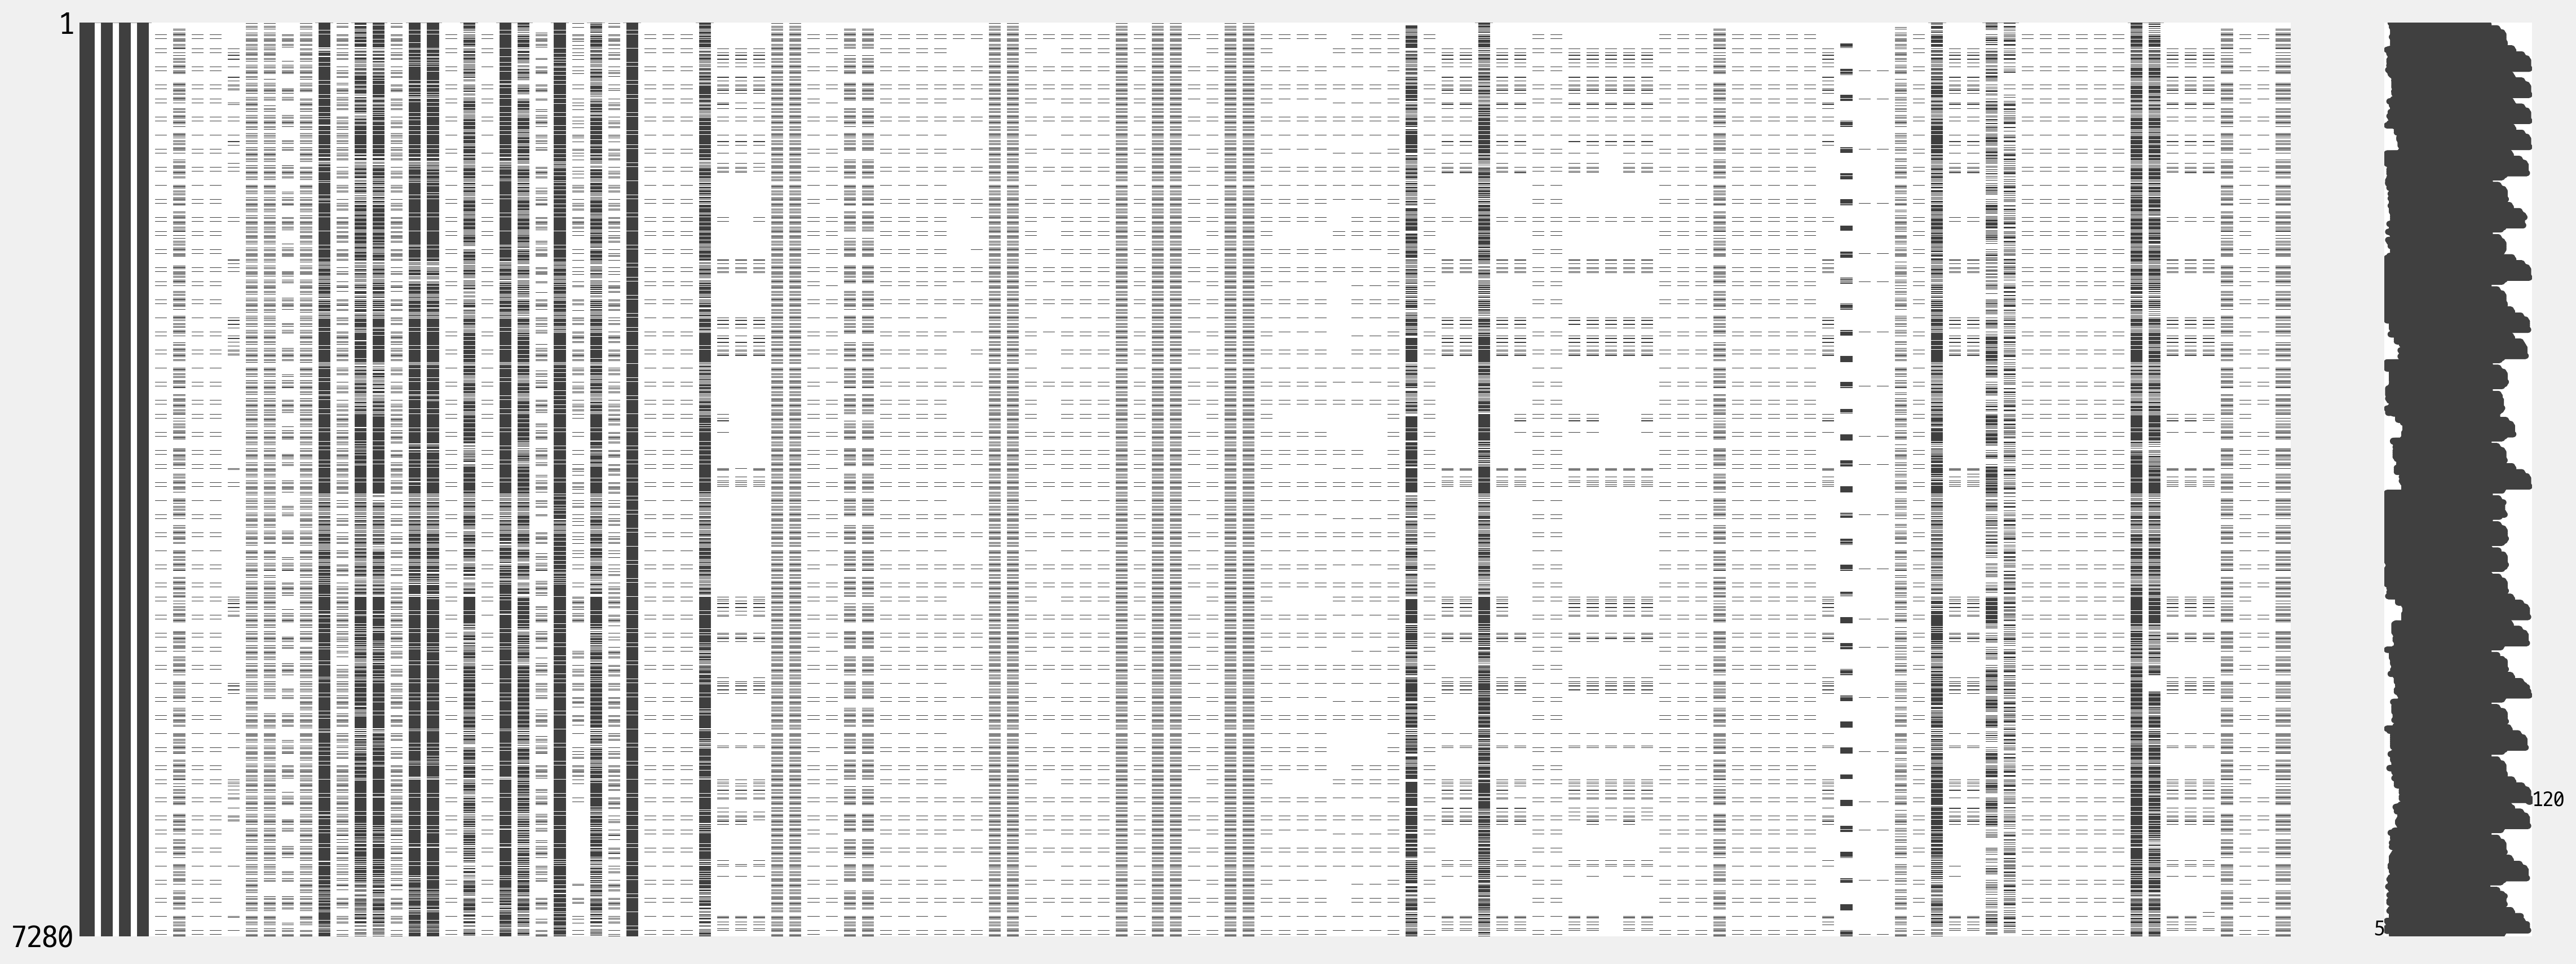

In [9]:
msno.matrix(pvtb_entire)

<Axes: >

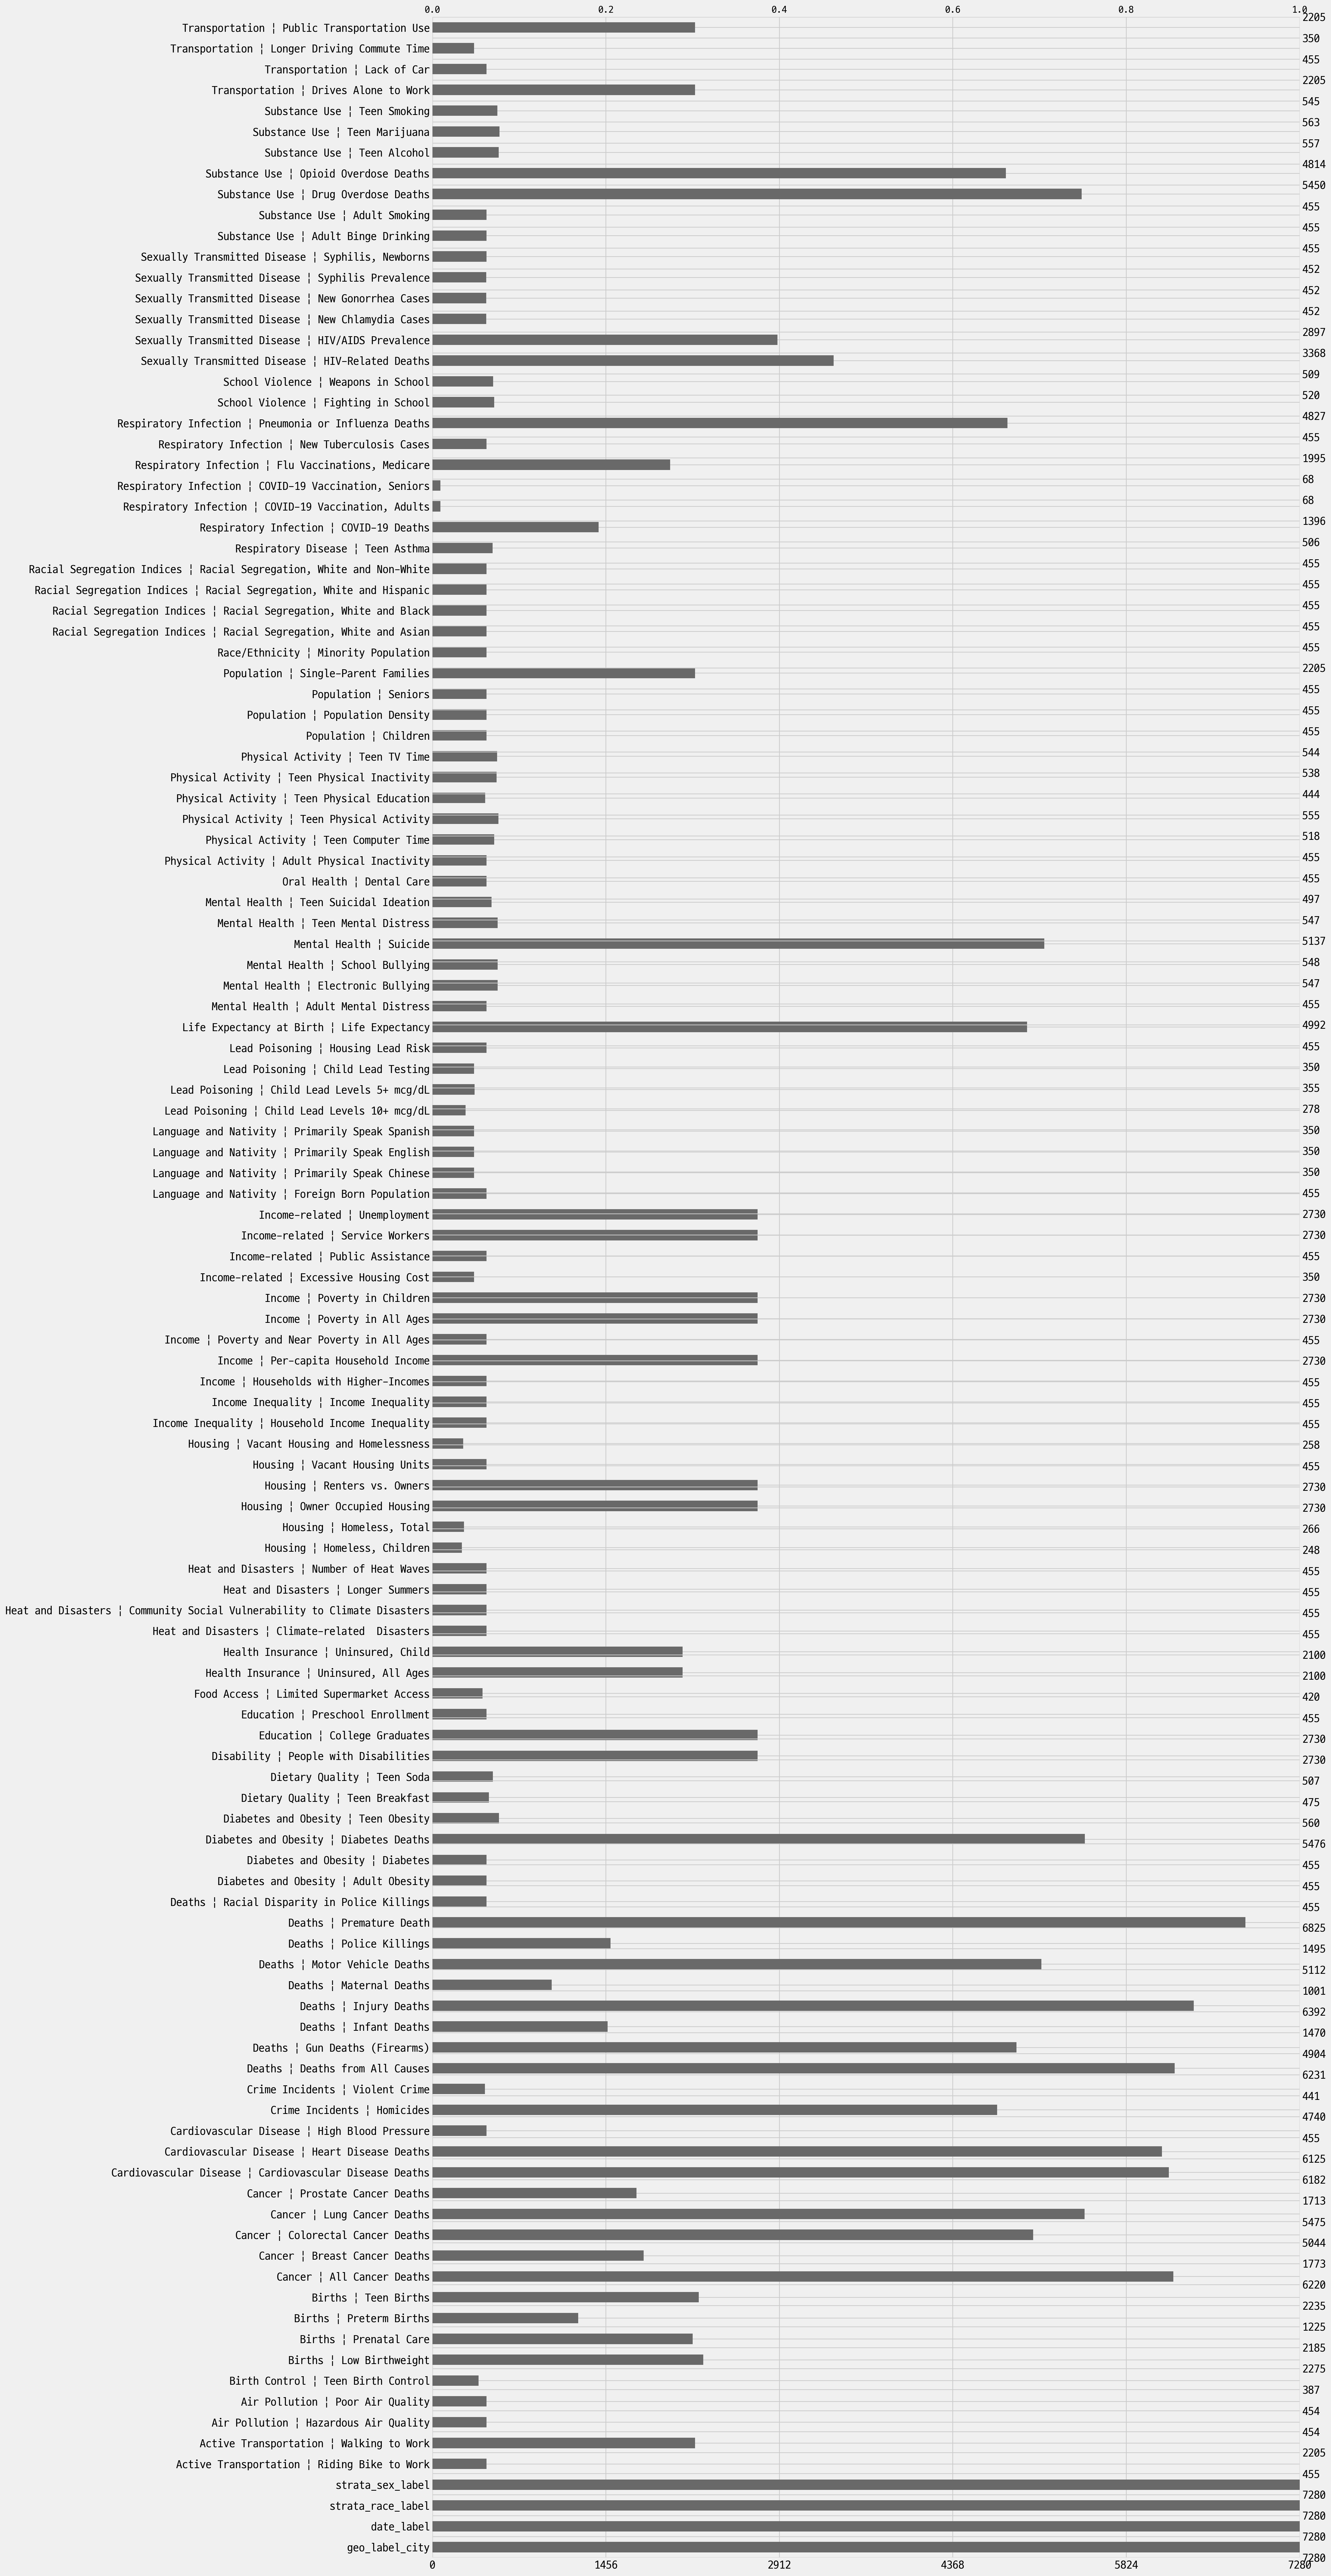

In [10]:
msno.bar(pvtb_entire)

<Axes: >

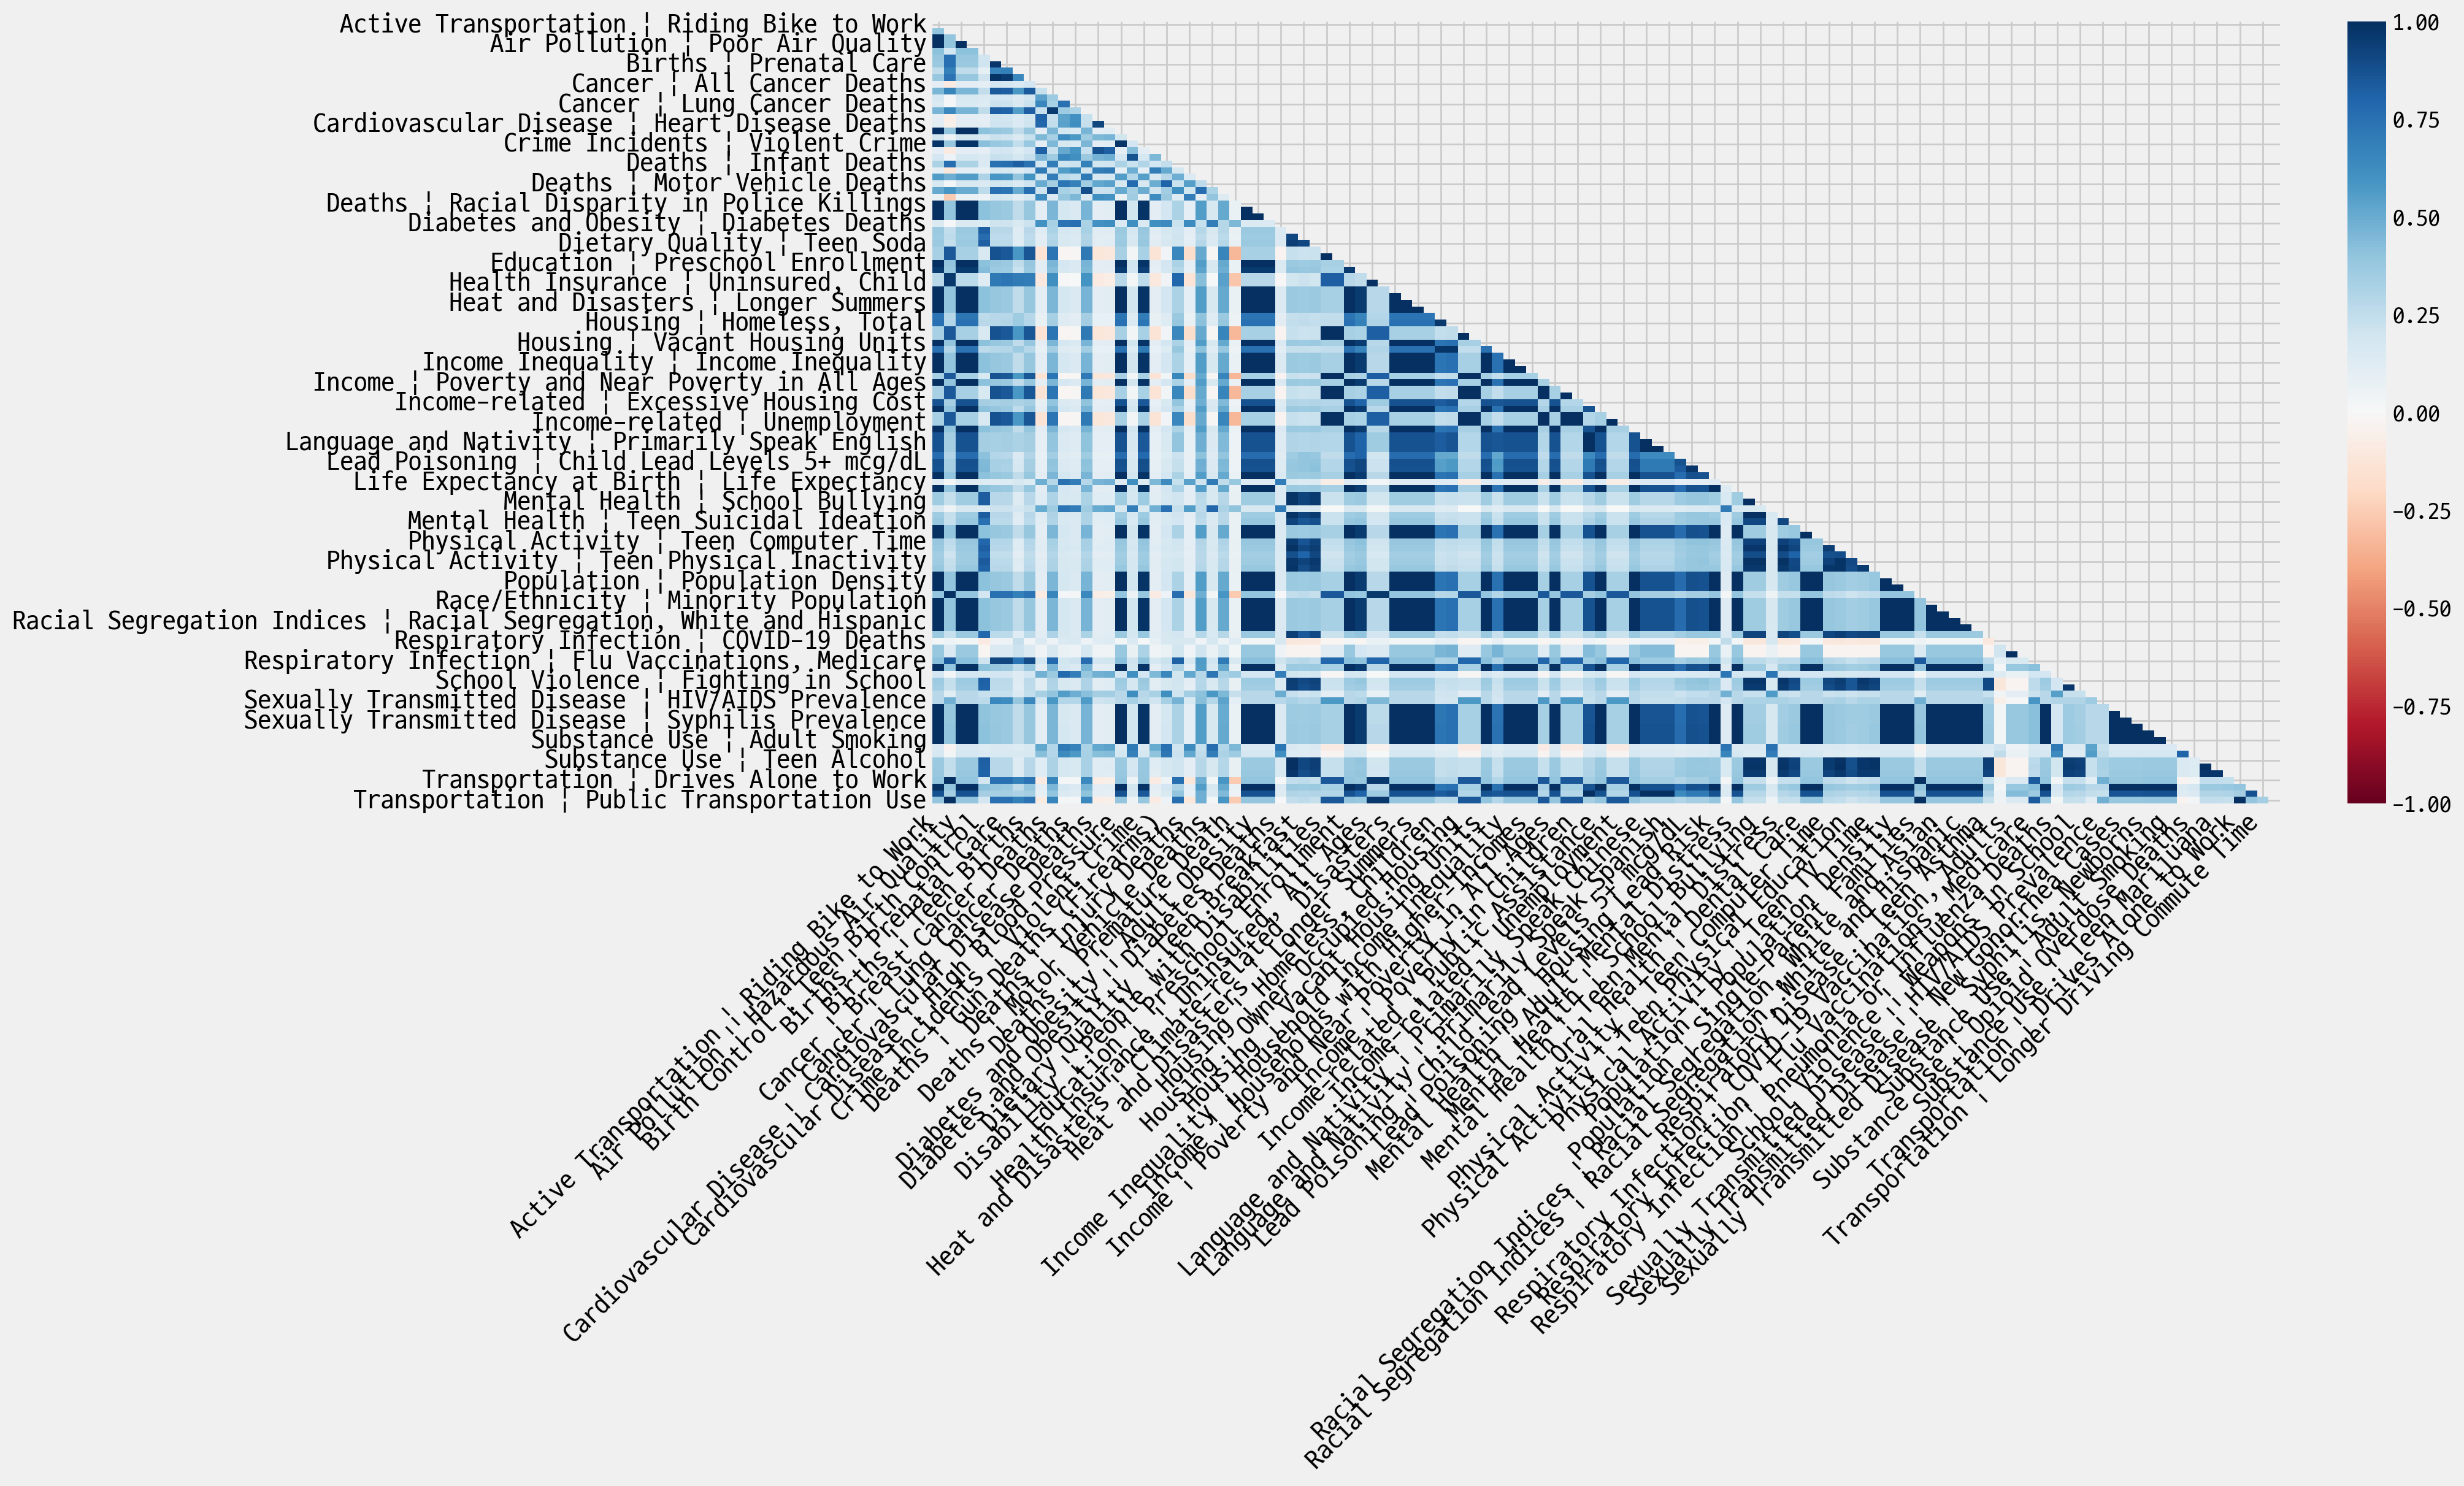

In [11]:
msno.heatmap(pvtb_entire, labels=False)

<Axes: >

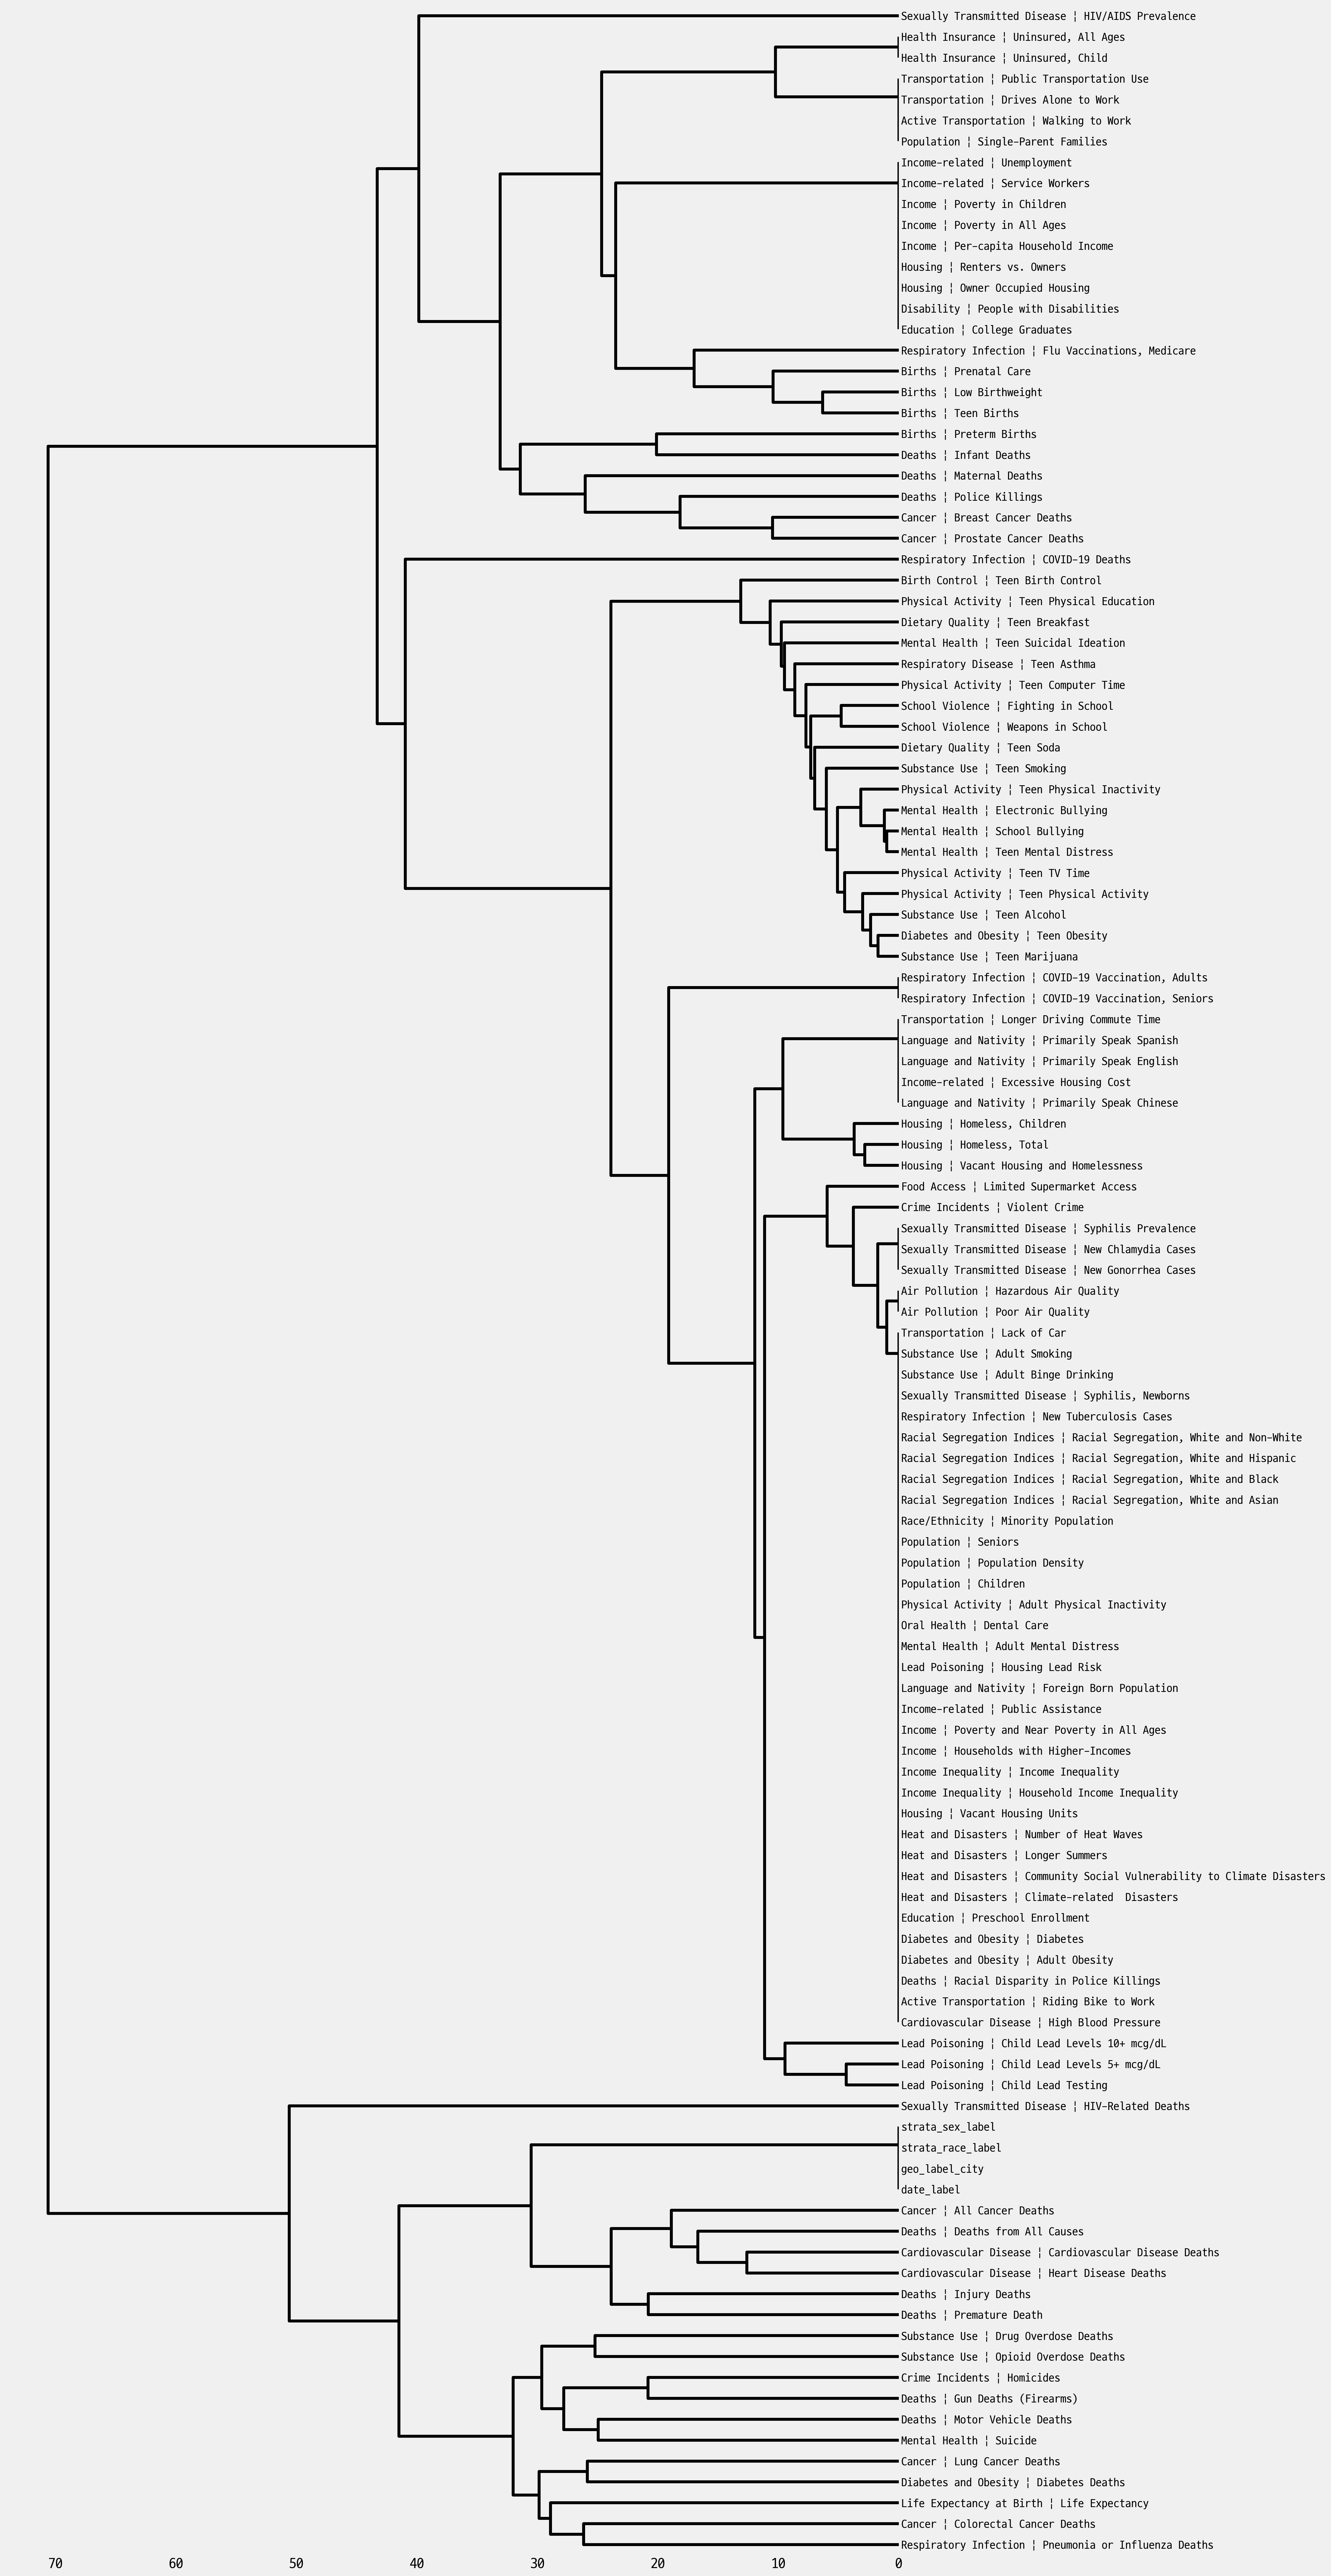

In [12]:
msno.dendrogram(pvtb_entire)

In [13]:
labels = pvtb_entire.columns[4:]

np.sum(~pvtb_entire[labels].isna(),axis=0)

Active Transportation | Riding Bike to Work      455
Active Transportation | Walking to Work         2205
Air Pollution | Hazardous Air Quality            454
Air Pollution | Poor Air Quality                 454
Birth Control | Teen Birth Control               387
                                                ... 
Substance Use | Teen Smoking                     545
Transportation | Drives Alone to Work           2205
Transportation | Lack of Car                     455
Transportation | Longer Driving Commute Time     350
Transportation | Public Transportation Use      2205
Length: 118, dtype: int64

### filter label that almost filled

1. entire 기준으로 80% 이상 있는 label이 뭐가 있는지 확인
2. total 기준 전부 다 있는 label이 entire 기준으로는 어느정도 있는지 확인

In [14]:
pvtb_entire_T = pvtb_entire.T
(pvtb_entire_T[np.sum(pvtb_entire_T.isna(),axis=1) < 7280 * 0.25].index)

Index(['geo_label_city', 'date_label', 'strata_race_label', 'strata_sex_label',
       'Cancer | All Cancer Deaths', 'Cancer | Lung Cancer Deaths',
       'Cardiovascular Disease | Cardiovascular Disease Deaths',
       'Cardiovascular Disease | Heart Disease Deaths',
       'Deaths | Deaths from All Causes', 'Deaths | Injury Deaths',
       'Deaths | Premature Death', 'Diabetes and Obesity | Diabetes Deaths'],
      dtype='object')

In [15]:
pvtb_entire_T = pvtb_entire.T
pvtb_entire_T[np.sum(pvtb_entire_T.isna(),axis=1) < 7280 * 0.4].index

Index(['geo_label_city', 'date_label', 'strata_race_label', 'strata_sex_label',
       'Cancer | All Cancer Deaths', 'Cancer | Colorectal Cancer Deaths',
       'Cancer | Lung Cancer Deaths',
       'Cardiovascular Disease | Cardiovascular Disease Deaths',
       'Cardiovascular Disease | Heart Disease Deaths',
       'Crime Incidents | Homicides', 'Deaths | Deaths from All Causes',
       'Deaths | Gun Deaths (Firearms)', 'Deaths | Injury Deaths',
       'Deaths | Motor Vehicle Deaths', 'Deaths | Premature Death',
       'Diabetes and Obesity | Diabetes Deaths',
       'Life Expectancy at Birth | Life Expectancy', 'Mental Health | Suicide',
       'Respiratory Infection | Pneumonia or Influenza Deaths',
       'Substance Use | Drug Overdose Deaths',
       'Substance Use | Opioid Overdose Deaths'],
      dtype='object')

In [16]:
ths = 0.3
num_entire = 13*35*18
cond0 = np.sum(pvtb_entire_T.isna(),axis=1) < len(pvtb_entire_T.columns) * ths
rslt = np.sum(~pvtb_entire_T[cond0].isna(),axis=1).sort_values(ascending=False).reset_index()
rslt['ratio'] = rslt[0]/len(pvtb_entire_T.columns) * 100
rslt

index     0       ratio
0                                      geo_label_city  7280  100.000000
1                                          date_label  7280  100.000000
2                                   strata_race_label  7280  100.000000
3                                    strata_sex_label  7280  100.000000
4                            Deaths | Premature Death  6825   93.750000
5                              Deaths | Injury Deaths  6392   87.802198
6                     Deaths | Deaths from All Causes  6231   85.590659
7                          Cancer | All Cancer Deaths  6220   85.439560
8   Cardiovascular Disease | Cardiovascular Diseas...  6182   84.917582
9       Cardiovascular Disease | Heart Disease Deaths  6125   84.134615
10             Diabetes and Obesity | Diabetes Deaths  5476   75.219780
11                        Cancer | Lung Cancer Deaths  5475   75.206044
12               Substance Use | Drug Overdose Deaths  5450   74.862637
13                            Mental Health | Suicide  5137   70.563187
14                      Deaths | Motor Vehicle Deaths  5112   70.219780

In [17]:
rslt['index']

0                                        geo_label_city
1                                            date_label
2                                     strata_race_label
3                                      strata_sex_label
4                              Deaths | Premature Death
5                                Deaths | Injury Deaths
6                       Deaths | Deaths from All Causes
7                            Cancer | All Cancer Deaths
8     Cardiovascular Disease | Cardiovascular Diseas...
9         Cardiovascular Disease | Heart Disease Deaths
10               Diabetes and Obesity | Diabetes Deaths
11                          Cancer | Lung Cancer Deaths
12                 Substance Use | Drug Overdose Deaths
13                              Mental Health | Suicide
14                        Deaths | Motor Vehicle Deaths
Name: index, dtype: object

In [18]:
ths = 0.3
num_entire = 13*35*18
cond0 = np.sum(pvtb_entire_T.isna(),axis=1) < num_entire * ths
rslt = np.sum(~pvtb_entire_T[cond0].isna(),axis=1).sort_values(ascending=False).reset_index()
rslt['ratio'] = rslt[0]/num_entire * 100
print(num_entire)
rslt

8190


index     0      ratio
0                                      geo_label_city  7280  88.888889
1                                          date_label  7280  88.888889
2                                   strata_race_label  7280  88.888889
3                                    strata_sex_label  7280  88.888889
4                            Deaths | Premature Death  6825  83.333333
5                              Deaths | Injury Deaths  6392  78.046398
6                     Deaths | Deaths from All Causes  6231  76.080586
7                          Cancer | All Cancer Deaths  6220  75.946276
8   Cardiovascular Disease | Cardiovascular Diseas...  6182  75.482295
9       Cardiovascular Disease | Heart Disease Deaths  6125  74.786325
10             Diabetes and Obesity | Diabetes Deaths  5476  66.862027
11                        Cancer | Lung Cancer Deaths  5475  66.849817
12               Substance Use | Drug Overdose Deaths  5450  66.544567
13                            Mental Health | Suicide  5137  62.722833
14                      Deaths | Motor Vehicle Deaths  5112  62.417582
15                  Cancer | Colorectal Cancer Deaths  5044  61.587302
16         Life Expectancy at Birth | Life Expectancy  4992  60.952381
17                     Deaths | Gun Deaths (Firearms)  4904  59.877900
18  Respiratory Infection | Pneumonia or Influenza...  4827  58.937729

- 전체 7280개는 어떻게 구성된 데이터인지

In [19]:
display(pvtb_entire[["geo_label_city",'date_label']].value_counts())
display(np.sum(pvtb_entire[["geo_label_city",'date_label']].value_counts()))

geo_label_city  date_label
Austin          2010          16
Minneapolis     2022          16
Oakland         2022          16
                2021          16
                2020          16
                              ..
Fort Worth      2015          16
                2014          16
                2013          16
                2012          16
Washington      2022          16
Name: count, Length: 455, dtype: int64

7280

In [20]:
row_count = pvtb_entire[['geo_label_city','strata_race_label']].fillna('NAN').value_counts().reset_index().sort_values(by=['geo_label_city','strata_race_label'])
row_count

geo_label_city strata_race_label  count
0           Austin               All     39
32          Austin          Asian/PI     39
122         Austin             Black     39
123         Austin          Hispanic     39
180         Austin           Natives     13
..             ...               ...    ...
67      Washington          Asian/PI     39
68      Washington             Black     39
69      Washington          Hispanic     39
176     Washington           Natives     13
143     Washington             White     39

[210 rows x 3 columns]

In [21]:
display(row_count['geo_label_city'].value_counts())
display(35*6)

geo_label_city
Austin           6
Phoenix          6
Milwaukee        6
Minneapolis      6
New York City    6
Oakland          6
Oklahoma City    6
Philadelphia     6
Portland         6
Louisville       6
San Antonio      6
San Diego        6
San Francisco    6
San Jose         6
Seattle          6
Tucson           6
Memphis          6
Los Angeles      6
Baltimore        6
Denver           6
Boston           6
Charlotte        6
Chicago          6
Cleveland        6
Columbus         6
Dallas           6
Detroit          6
Long Beach       6
El Paso          6
Fort Worth       6
Houston          6
Indianapolis     6
Kansas City      6
Las Vegas        6
Washington       6
Name: count, dtype: int64

210

In [22]:
row_count = pvtb_entire[['geo_label_city','strata_sex_label']].fillna('NAN').value_counts().reset_index().sort_values(by=['geo_label_city','strata_sex_label'])
np.sum(row_count['geo_label_city'].value_counts()), 35*3

(105, 105)

In [23]:
35*13*16

7280

In [24]:
row_count = pvtb_entire[['strata_race_label','strata_sex_label']].fillna('NAN').value_counts().reset_index().sort_values(by=['strata_race_label','strata_sex_label'])
row_count

strata_race_label strata_sex_label  count
0                All             Both    455
1                All           Female    455
2                All             Male    455
3           Asian/PI             Both    455
4           Asian/PI           Female    455
5           Asian/PI             Male    455
6              Black             Both    455
7              Black           Female    455
8              Black             Male    455
9           Hispanic             Both    455
10          Hispanic           Female    455
11          Hispanic             Male    455
12           Natives             Both    455
13             White             Both    455
14             White           Female    455
15             White             Male    455

- 연도/도시별로 race-sex에 대해서 데이터 row가 있음
    - natives를 제외하고는 모든 race에 대해서 모든 sex의 조합으로 데이터 row 존재
        - natives에 대해서는 성별이 both 밖에 없음
    - 데이터 row의 값이 nan일 수는 있음

### 결측률 확인
- 연도/도시 기준으로 결측률
    1. 하나의 데이터라도 있는지가 기준
    2. All-Both가 있는지를 기준
   - stratification data 만을 기준으로 결측률 확인
    3. All, Both 제외 하나라도 있으면 있는 것 기준
    4. All, Both 제외 두 개 이상 있는 것 기준
    5. 전체 race-sex에서 ths 이상 있는 것 기준
        - ths = 0.5, 0.7

1. 각 label 별로 7*17 에 plot
    - count/ ratio
2. y축 label, x축 연도로 해서 plot
    - 이 경우 ratio를 기준으로 색을 할 수 있을 것 같음
        - 도시 별로 집계한 것을 다시 집계하는 것은 큰 의미가 없을 듯
    - heatmap으로 그리면 될 듯 
3. y축 label, x축 도시로 해서 plot
    - 도시간 정렬은 records 양 순서대로
4. (2와 3통합)

In [25]:
pvtb_entire_miss = pvtb_entire.copy()
pvtb_entire_miss[labels] = pvtb_entire_miss[labels].isna()

pvtb_entire_miss

geo_label_city  date_label strata_race_label strata_sex_label  \
0            Austin        2010               All             Both   
1            Austin        2010               All           Female   
2            Austin        2010               All             Male   
3            Austin        2010          Asian/PI             Both   
4            Austin        2010          Asian/PI           Female   
...             ...         ...               ...              ...   
7275     Washington        2022          Hispanic             Male   
7276     Washington        2022           Natives             Both   
7277     Washington        2022             White             Both   
7278     Washington        2022             White           Female   
7279     Washington        2022             White             Male   

      Active Transportation | Riding Bike to Work  \
0                                           False   
1                                            True   
2                                            True   
3                                            True   
4                                            True   
...                                           ...   
7275                                         True   
7276                                         True   
7277                                         True   
7278                                         True   
7279                                         True   

      Active Transportation | Walking to Work  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   
...                                       ...   
7275                                     True   
7276                                    False   
7277                                    False   
7278                                     True   
7279                                     True   

      Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
0                                     False                             False   
1                                      True                              True   
2                                      True                              True   
3                                      True                              True   
4                                      True                              True   
...                                     ...                               ...   
7275                                   True                              True   
7276                                   True                              True   
7277                                   True                              True   
7278                                   True                              True   
7279                                   True                              True   

      Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
0                                   True                     False  ...   
1                                   True                      True  ...   
2                                   True                      True  ...   
3                                   True                     False  ...   
4                                   True                      True  ...   
...                                  ...                       ...  ...   
7275                                True                      True  ...   
7276                                True                      True  ...   
7277                                True                     False  ...   
7278                                True                      True  ...   
7279                                True                      True  ...   

      Substance Use | Adult Smoking  Substance Use | Drug Overdo

In [26]:
basic_key = ['geo_label_city','date_label']

In [27]:
labels = list(labels)
strat_cols = ['strata_race_label','strata_sex_label']

1. 하나의 데이터라도 있는지가 기준

In [28]:
miss_check = pd.pivot_table(data=pvtb_entire_miss,index=basic_key,values=labels,aggfunc=np.sum)
miss_check

Active Transportation | Riding Bike to Work  \
geo_label_city date_label                                                
Austin         2010                                                 15   
               2011                                                 15   
               2012                                                 15   
               2013                                                 15   
               2014                                                 15   
...                                                                ...   
Washington     2018                                                 15   
               2019                                                 15   
               2020                                                 15   
               2021                                                 15   
               2022                                                 15   

                           Active Transportation | Walking to Work  \
geo_label_city date_label                                            
Austin         2010                                             15   
               2011                                             15   
               2012                                             15   
               2013                                             10   
               2014                                             10   
...                                                            ...   
Washington     2018                                             10   
               2019                                             10   
               2020                                             10   
               2021                                             10   
               2022                                             10   

                           Air Pollution | Hazardous Air Quality  \
geo_label_city date_label                                          
Austin         2010                                           15   
               2011                                           15   
               2012                                           15   
               2013                                           15   
               2014                                           15   
...                                                          ...   
Washington     2018                                           15   
               2019                                           15   
               2020                                           15   
               2021                                           15   
               2022                                           15   

                           Air Pollution | Poor Air Quality  \
geo_label_city date_label                                     
Austin         2010                                      15   
               2011                                      15   
               2012                                      15   
               2013                                      15   
               2014                                      15   
...                                                     ...   
Washington     2018                                      15   
               2019                                      15   
               2020                                      15   
               2021                                      15   
               2022                                      15   

                           Birth Control | Teen Birth Control  \
geo_label_city date_label                                       
Austin         2010                                        16   
               2011                                        16   
               2012                                        16   
               2013                                        16   
               2014                                       

In [29]:
label_miss_check = miss_check < 16
np.mean(label_miss_check,axis=0).sort_values(ascending=False)

Active Transportation | Riding Bike to Work              1.000000
Physical Activity | Adult Physical Inactivity            1.000000
Mental Health | Suicide                                  1.000000
Mental Health | Adult Mental Distress                    1.000000
Lead Poisoning | Housing Lead Risk                       1.000000
                                                           ...   
School Violence | Weapons in School                      0.410989
Physical Activity | Teen Physical Education              0.386813
Respiratory Infection | COVID-19 Deaths                  0.230769
Respiratory Infection | COVID-19 Vaccination, Seniors    0.149451
Respiratory Infection | COVID-19 Vaccination, Adults     0.149451
Length: 118, dtype: float64

In [30]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[60:80]

Deaths | Police Killings                              1.000000
Transportation | Public Transportation Use            1.000000
Education | Preschool Enrollment                      1.000000
Disability | People with Disabilities                 1.000000
Education | College Graduates                         1.000000
Diabetes and Obesity | Diabetes Deaths                1.000000
Deaths | Racial Disparity in Police Killings          1.000000
Diabetes and Obesity | Adult Obesity                  1.000000
Diabetes and Obesity | Diabetes                       1.000000
Air Pollution | Hazardous Air Quality                 0.997802
Air Pollution | Poor Air Quality                      0.997802
Sexually Transmitted Disease | New Chlamydia Cases    0.993407
Sexually Transmitted Disease | New Gonorrhea Cases    0.993407
Sexually Transmitted Disease | Syphilis Prevalence    0.993407
Substance Use | Opioid Overdose Deaths                0.982418
Crime Incidents | Violent Crime                       0

In [31]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[80:100]

Deaths | Maternal Deaths                           0.885714
Lead Poisoning | Child Lead Levels 5+ mcg/dL       0.780220
Health Insurance | Uninsured, Child                0.769231
Health Insurance | Uninsured, All Ages             0.769231
Language and Nativity | Primarily Speak English    0.769231
Transportation | Longer Driving Commute Time       0.769231
Language and Nativity | Primarily Speak Chinese    0.769231
Language and Nativity | Primarily Speak Spanish    0.769231
Lead Poisoning | Child Lead Testing                0.769231
Income-related | Excessive Housing Cost            0.769231
Deaths | Infant Deaths                             0.692308
Lead Poisoning | Child Lead Levels 10+ mcg/dL      0.610989
Housing | Homeless, Total                          0.584615
Housing | Vacant Housing and Homelessness          0.567033
Housing | Homeless, Children                       0.545055
Births | Preterm Births                            0.538462
Physical Activity | Teen Computer Time  

In [32]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[100:]

Substance Use | Teen Smoking                             0.459341
Physical Activity | Teen TV Time                         0.459341
Diabetes and Obesity | Teen Obesity                      0.459341
Mental Health | Electronic Bullying                      0.435165
Mental Health | School Bullying                          0.435165
Dietary Quality | Teen Soda                              0.435165
Mental Health | Teen Mental Distress                     0.435165
Mental Health | Teen Suicidal Ideation                   0.435165
School Violence | Fighting in School                     0.435165
Physical Activity | Teen Physical Inactivity             0.435165
Respiratory Disease | Teen Asthma                        0.435165
Dietary Quality | Teen Breakfast                         0.410989
Birth Control | Teen Birth Control                       0.410989
School Violence | Weapons in School                      0.410989
Physical Activity | Teen Physical Education              0.386813
Respirator

- 도시/연도 별로 집계 하였을 때
    - 약 70여개 가량의 label이 모든 도시/연도에 대해서 최소 하나의 데이터가 있음
    - 약 90여개 가량의 label이 모든 도시/연도 중 75% 이상에 대해서 각각 최소 하나의 데이터가 있음  

2. All-Both가 있는지를 기준

In [33]:
cond_race_all = pvtb_entire_miss['strata_race_label'] == 'All'
cond_sex_both = pvtb_entire_miss['strata_sex_label'] == 'Both'

pvtb_total_miss=pvtb_entire_miss[cond_race_all & cond_sex_both]
pvtb_total_miss

geo_label_city  date_label strata_race_label strata_sex_label  \
0            Austin        2010               All             Both   
16           Austin        2011               All             Both   
32           Austin        2012               All             Both   
48           Austin        2013               All             Both   
64           Austin        2014               All             Both   
...             ...         ...               ...              ...   
7200     Washington        2018               All             Both   
7216     Washington        2019               All             Both   
7232     Washington        2020               All             Both   
7248     Washington        2021               All             Both   
7264     Washington        2022               All             Both   

      Active Transportation | Riding Bike to Work  \
0                                           False   
16                                          False   
32                                          False   
48                                          False   
64                                          False   
...                                           ...   
7200                                        False   
7216                                        False   
7232                                        False   
7248                                        False   
7264                                        False   

      Active Transportation | Walking to Work  \
0                                       False   
16                                      False   
32                                      False   
48                                      False   
64                                      False   
...                                       ...   
7200                                    False   
7216                                    False   
7232                                    False   
7248                                    False   
7264                                    False   

      Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
0                                     False                             False   
16                                    False                             False   
32                                    False                             False   
48                                    False                             False   
64                                    False                             False   
...                                     ...                               ...   
7200                                  False                             False   
7216                                  False                             False   
7232                                  False                             False   
7248                                  False                             False   
7264                                  False                             False   

      Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
0                                   True                     False  ...   
16                                  True                     False  ...   
32                                  True                     False  ...   
48                                  True                     False  ...   
64                                  True                     False  ...   
...                                  ...                       ...  ...   
7200                               False                     False  ...   
7216                               False                     False  ...   
7232                               False                     False  ...   
7248                                True                     False  ...   
7264                                True                     False  ...   

      Substance Use | Adult Smoking  Substance Use | Drug Overdo

In [34]:
miss_check = pd.pivot_table(data=pvtb_total_miss,index=basic_key,values=labels,aggfunc=np.sum)
miss_check

Active Transportation | Riding Bike to Work  \
geo_label_city date_label                                                
Austin         2010                                                  0   
               2011                                                  0   
               2012                                                  0   
               2013                                                  0   
               2014                                                  0   
...                                                                ...   
Washington     2018                                                  0   
               2019                                                  0   
               2020                                                  0   
               2021                                                  0   
               2022                                                  0   

                           Active Transportation | Walking to Work  \
geo_label_city date_label                                            
Austin         2010                                              0   
               2011                                              0   
               2012                                              0   
               2013                                              0   
               2014                                              0   
...                                                            ...   
Washington     2018                                              0   
               2019                                              0   
               2020                                              0   
               2021                                              0   
               2022                                              0   

                           Air Pollution | Hazardous Air Quality  \
geo_label_city date_label                                          
Austin         2010                                            0   
               2011                                            0   
               2012                                            0   
               2013                                            0   
               2014                                            0   
...                                                          ...   
Washington     2018                                            0   
               2019                                            0   
               2020                                            0   
               2021                                            0   
               2022                                            0   

                           Air Pollution | Poor Air Quality  \
geo_label_city date_label                                     
Austin         2010                                       0   
               2011                                       0   
               2012                                       0   
               2013                                       0   
               2014                                       0   
...                                                     ...   
Washington     2018                                       0   
               2019                                       0   
               2020                                       0   
               2021                                       0   
               2022                                       0   

                           Birth Control | Teen Birth Control  \
geo_label_city date_label                                       
Austin         2010                                         1   
               2011                                         1   
               2012                                         1   
               2013                                         1   
               2014                                       

In [35]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False)

Active Transportation | Riding Bike to Work              1.000000
Physical Activity | Adult Physical Inactivity            1.000000
Mental Health | Suicide                                  1.000000
Mental Health | Adult Mental Distress                    1.000000
Lead Poisoning | Housing Lead Risk                       1.000000
                                                           ...   
School Violence | Weapons in School                      0.410989
Physical Activity | Teen Physical Education              0.386813
Respiratory Infection | COVID-19 Deaths                  0.230769
Respiratory Infection | COVID-19 Vaccination, Seniors    0.149451
Respiratory Infection | COVID-19 Vaccination, Adults     0.149451
Length: 118, dtype: float64

In [36]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[60:80]

Deaths | Police Killings                              1.000000
Transportation | Public Transportation Use            1.000000
Education | Preschool Enrollment                      1.000000
Disability | People with Disabilities                 1.000000
Education | College Graduates                         1.000000
Diabetes and Obesity | Diabetes Deaths                1.000000
Deaths | Racial Disparity in Police Killings          1.000000
Diabetes and Obesity | Adult Obesity                  1.000000
Diabetes and Obesity | Diabetes                       1.000000
Air Pollution | Hazardous Air Quality                 0.997802
Air Pollution | Poor Air Quality                      0.997802
Sexually Transmitted Disease | New Chlamydia Cases    0.993407
Sexually Transmitted Disease | New Gonorrhea Cases    0.993407
Sexually Transmitted Disease | Syphilis Prevalence    0.993407
Substance Use | Opioid Overdose Deaths                0.982418
Crime Incidents | Violent Crime                       0

In [37]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[80:100]

Deaths | Maternal Deaths                           0.885714
Lead Poisoning | Child Lead Levels 5+ mcg/dL       0.780220
Health Insurance | Uninsured, Child                0.769231
Health Insurance | Uninsured, All Ages             0.769231
Language and Nativity | Primarily Speak English    0.769231
Transportation | Longer Driving Commute Time       0.769231
Language and Nativity | Primarily Speak Chinese    0.769231
Language and Nativity | Primarily Speak Spanish    0.769231
Lead Poisoning | Child Lead Testing                0.769231
Income-related | Excessive Housing Cost            0.769231
Deaths | Infant Deaths                             0.692308
Lead Poisoning | Child Lead Levels 10+ mcg/dL      0.610989
Housing | Homeless, Total                          0.584615
Housing | Vacant Housing and Homelessness          0.567033
Housing | Homeless, Children                       0.545055
Births | Preterm Births                            0.538462
Physical Activity | Teen Computer Time  

In [38]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[100:]

Substance Use | Teen Smoking                             0.459341
Physical Activity | Teen TV Time                         0.459341
Diabetes and Obesity | Teen Obesity                      0.459341
Mental Health | Electronic Bullying                      0.435165
Mental Health | School Bullying                          0.435165
Dietary Quality | Teen Soda                              0.435165
Mental Health | Teen Mental Distress                     0.435165
Mental Health | Teen Suicidal Ideation                   0.435165
School Violence | Fighting in School                     0.435165
Physical Activity | Teen Physical Inactivity             0.435165
Respiratory Disease | Teen Asthma                        0.435165
Dietary Quality | Teen Breakfast                         0.410989
Birth Control | Teen Birth Control                       0.410989
School Violence | Weapons in School                      0.410989
Physical Activity | Teen Physical Education              0.386813
Respirator

- 도시/연도 별로 집계 하였을 때
    - 약 70여개 가량의 label이 모든 도시/연도에 대해서 race-sex가 All-Both인 데이터가 있음
    - 약 90여개 가량의 label이 모든 도시/연도 중 75% 이상에 대해서 race-sex가 All-Both인 데이터가 있음  

3. All, Both 제외 하나라도 있으면 있는 것 기준
- 16개 중 All-Both만 제외했을 때

In [39]:
cond_race_all = pvtb_entire_miss['strata_race_label'] == 'All'
cond_sex_both = pvtb_entire_miss['strata_sex_label'] == 'Both'

pvtb_strata_any_miss=pvtb_entire_miss[~(cond_race_all & cond_sex_both)]
pvtb_strata_any_miss

geo_label_city  date_label strata_race_label strata_sex_label  \
1            Austin        2010               All           Female   
2            Austin        2010               All             Male   
3            Austin        2010          Asian/PI             Both   
4            Austin        2010          Asian/PI           Female   
5            Austin        2010          Asian/PI             Male   
...             ...         ...               ...              ...   
7275     Washington        2022          Hispanic             Male   
7276     Washington        2022           Natives             Both   
7277     Washington        2022             White             Both   
7278     Washington        2022             White           Female   
7279     Washington        2022             White             Male   

      Active Transportation | Riding Bike to Work  \
1                                            True   
2                                            True   
3                                            True   
4                                            True   
5                                            True   
...                                           ...   
7275                                         True   
7276                                         True   
7277                                         True   
7278                                         True   
7279                                         True   

      Active Transportation | Walking to Work  \
1                                        True   
2                                        True   
3                                        True   
4                                        True   
5                                        True   
...                                       ...   
7275                                     True   
7276                                    False   
7277                                    False   
7278                                     True   
7279                                     True   

      Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
1                                      True                              True   
2                                      True                              True   
3                                      True                              True   
4                                      True                              True   
5                                      True                              True   
...                                     ...                               ...   
7275                                   True                              True   
7276                                   True                              True   
7277                                   True                              True   
7278                                   True                              True   
7279                                   True                              True   

      Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
1                                   True                      True  ...   
2                                   True                      True  ...   
3                                   True                     False  ...   
4                                   True                      True  ...   
5                                   True                      True  ...   
...                                  ...                       ...  ...   
7275                                True                      True  ...   
7276                                True                      True  ...   
7277                                True                     False  ...   
7278                                True                      True  ...   
7279                                True                      True  ...   

      Substance Use | Adult Smoking  Substance Use | Drug Overdo

In [40]:
import functools

def cond_check_dict(data=pd.DataFrame,val_dict=dict):
    cond_list=[
        data[col] == val
        for col, val in val_dict.items()
    ]
    return functools.reduce(lambda x,y: x & y, cond_list)

In [41]:
val_dict = {
    'geo_label_city' : 'Austin',
    'date_label' : 2011
}
cond = cond_check_dict(pvtb_strata_any_miss,val_dict)
np.sum(cond)

15

In [42]:
pvtb_strata_any_miss[cond]

geo_label_city  date_label strata_race_label strata_sex_label  \
17         Austin        2011               All           Female   
18         Austin        2011               All             Male   
19         Austin        2011          Asian/PI             Both   
20         Austin        2011          Asian/PI           Female   
21         Austin        2011          Asian/PI             Male   
22         Austin        2011             Black             Both   
23         Austin        2011             Black           Female   
24         Austin        2011             Black             Male   
25         Austin        2011          Hispanic             Both   
26         Austin        2011          Hispanic           Female   
27         Austin        2011          Hispanic             Male   
28         Austin        2011           Natives             Both   
29         Austin        2011             White             Both   
30         Austin        2011             White           Female   
31         Austin        2011             White             Male   

    Active Transportation | Riding Bike to Work  \
17                                         True   
18                                         True   
19                                         True   
20                                         True   
21                                         True   
22                                         True   
23                                         True   
24                                         True   
25                                         True   
26                                         True   
27                                         True   
28                                         True   
29                                         True   
30                                         True   
31                                         True   

    Active Transportation | Walking to Work  \
17                                     True   
18                                     True   
19                                     True   
20                                     True   
21                                     True   
22                                     True   
23                                     True   
24                                     True   
25                                     True   
26                                     True   
27                                     True   
28                                     True   
29                                     True   
30                                     True   
31                                     True   

    Air Pollution | Hazardous Air Quality  Air Pollution | Poor Air Quality  \
17                                   True                              True   
18                                   True                              True   
19                                   True                              True   
20                                   True                              True   
21                                   True                              True   
22                                   True                              True   
23                                   True                              True   
24                                   True                              True   
25                                   True                              True   
26                                   True                              True   
27                                   True                              True   
28                                   True                              True   
29                                   True                              True   
30                                   True                              True   
31                                   True                              True   

    Birth Control | Teen Birth Control  Births | Low Birthweight  ...  \
17    

In [43]:
miss_check = pd.pivot_table(data=pvtb_strata_any_miss,index=basic_key,values=labels,aggfunc=np.sum)
miss_check

Active Transportation | Riding Bike to Work  \
geo_label_city date_label                                                
Austin         2010                                                 15   
               2011                                                 15   
               2012                                                 15   
               2013                                                 15   
               2014                                                 15   
...                                                                ...   
Washington     2018                                                 15   
               2019                                                 15   
               2020                                                 15   
               2021                                                 15   
               2022                                                 15   

                           Active Transportation | Walking to Work  \
geo_label_city date_label                                            
Austin         2010                                             15   
               2011                                             15   
               2012                                             15   
               2013                                             10   
               2014                                             10   
...                                                            ...   
Washington     2018                                             10   
               2019                                             10   
               2020                                             10   
               2021                                             10   
               2022                                             10   

                           Air Pollution | Hazardous Air Quality  \
geo_label_city date_label                                          
Austin         2010                                           15   
               2011                                           15   
               2012                                           15   
               2013                                           15   
               2014                                           15   
...                                                          ...   
Washington     2018                                           15   
               2019                                           15   
               2020                                           15   
               2021                                           15   
               2022                                           15   

                           Air Pollution | Poor Air Quality  \
geo_label_city date_label                                     
Austin         2010                                      15   
               2011                                      15   
               2012                                      15   
               2013                                      15   
               2014                                      15   
...                                                     ...   
Washington     2018                                      15   
               2019                                      15   
               2020                                      15   
               2021                                      15   
               2022                                      15   

                           Birth Control | Teen Birth Control  \
geo_label_city date_label                                       
Austin         2010                                        15   
               2011                                        15   
               2012                                        15   
               2013                                        15   
               2014                                       

In [44]:
label_miss_check = miss_check < 15
np.mean(label_miss_check,axis=0).sort_values(ascending=False)

Income-related | Service Workers                                            1.0
Income-related | Unemployment                                               1.0
Deaths | Gun Deaths (Firearms)                                              1.0
Deaths | Injury Deaths                                                      1.0
Deaths | Motor Vehicle Deaths                                               1.0
                                                                           ... 
Deaths | Racial Disparity in Police Killings                                0.0
Oral Health | Dental Care                                                   0.0
Physical Activity | Adult Physical Inactivity                               0.0
Heat and Disasters | Community Social Vulnerability to Climate Disasters    0.0
Active Transportation | Riding Bike to Work                                 0.0
Length: 118, dtype: float64

In [45]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[25:50]

Housing | Owner Occupied Housing                          1.000000
Cancer | Lung Cancer Deaths                               1.000000
Cancer | Prostate Cancer Deaths                           1.000000
Cardiovascular Disease | Cardiovascular Disease Deaths    1.000000
Cardiovascular Disease | Heart Disease Deaths             1.000000
Substance Use | Opioid Overdose Deaths                    0.982418
Births | Prenatal Care                                    0.960440
Life Expectancy at Birth | Life Expectancy                0.923077
Sexually Transmitted Disease | HIV/AIDS Prevalence        0.901099
Respiratory Infection | Flu Vaccinations, Medicare        0.846154
Health Insurance | Uninsured, Child                       0.769231
Population | Single-Parent Families                       0.769231
Active Transportation | Walking to Work                   0.769231
Transportation | Drives Alone to Work                     0.769231
Transportation | Public Transportation Use                0.76

- 도시/연도 별로 집계 하였을 때
    - 약 30여개 가량의 label이 모든 도시/연도에 대해서 race,sex 중 어느 한 쪽이라도 stratified 된 데이터가 있음
    - 약 40여개 가량의 label이 75% 이상의 도시/연도에 대해서 race,sex 중 어느 한 쪽이라도 stratified 된 데이터가 있음
    - 약 70여개 가량의 label은 15% 미만의 도시/연도에 대해서만 race,sex 중 어느 한 쪽이라도 stratified 된 데이터가 있음

4. 전체 race-sex에서 ths 이상 있는 것 기준
- ths = 0.5

In [46]:
miss_check = pd.pivot_table(data=pvtb_entire_miss,index=basic_key,values=labels,aggfunc=np.mean)
miss_check

Active Transportation | Riding Bike to Work  \
geo_label_city date_label                                                
Austin         2010                                             0.9375   
               2011                                             0.9375   
               2012                                             0.9375   
               2013                                             0.9375   
               2014                                             0.9375   
...                                                                ...   
Washington     2018                                             0.9375   
               2019                                             0.9375   
               2020                                             0.9375   
               2021                                             0.9375   
               2022                                             0.9375   

                           Active Transportation | Walking to Work  \
geo_label_city date_label                                            
Austin         2010                                         0.9375   
               2011                                         0.9375   
               2012                                         0.9375   
               2013                                         0.6250   
               2014                                         0.6250   
...                                                            ...   
Washington     2018                                         0.6250   
               2019                                         0.6250   
               2020                                         0.6250   
               2021                                         0.6250   
               2022                                         0.6250   

                           Air Pollution | Hazardous Air Quality  \
geo_label_city date_label                                          
Austin         2010                                       0.9375   
               2011                                       0.9375   
               2012                                       0.9375   
               2013                                       0.9375   
               2014                                       0.9375   
...                                                          ...   
Washington     2018                                       0.9375   
               2019                                       0.9375   
               2020                                       0.9375   
               2021                                       0.9375   
               2022                                       0.9375   

                           Air Pollution | Poor Air Quality  \
geo_label_city date_label                                     
Austin         2010                                  0.9375   
               2011                                  0.9375   
               2012                                  0.9375   
               2013                                  0.9375   
               2014                                  0.9375   
...                                                     ...   
Washington     2018                                  0.9375   
               2019                                  0.9375   
               2020                                  0.9375   
               2021                                  0.9375   
               2022                                  0.9375   

                           Birth Control | Teen Birth Control  \
geo_label_city date_label                                       
Austin         2010                                    1.0000   
               2011                                    1.0000   
               2012                                    1.0000   
               2013                                    1.0000   
               2014                                    1.0

In [47]:
miss_check = pd.pivot_table(data=pvtb_entire_miss,index=basic_key,values=labels,aggfunc=np.mean)
label_miss_check = miss_check < 0.5
np.mean(label_miss_check,axis=0).sort_values(ascending=False)

Deaths | Premature Death                                                    1.000000
Deaths | Injury Deaths                                                      1.000000
Cancer | All Cancer Deaths                                                  0.997802
Cardiovascular Disease | Cardiovascular Disease Deaths                      0.995604
Deaths | Deaths from All Causes                                             0.993407
                                                                              ...   
Housing | Homeless, Children                                                0.000000
Heat and Disasters | Number of Heat Waves                                   0.000000
Heat and Disasters | Longer Summers                                         0.000000
Heat and Disasters | Community Social Vulnerability to Climate Disasters    0.000000
Transportation | Public Transportation Use                                  0.000000
Length: 118, dtype: float64

In [48]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[:25]

Deaths | Premature Death                                  1.000000
Deaths | Injury Deaths                                    1.000000
Cancer | All Cancer Deaths                                0.997802
Cardiovascular Disease | Cardiovascular Disease Deaths    0.995604
Deaths | Deaths from All Causes                           0.993407
Substance Use | Drug Overdose Deaths                      0.993407
Cardiovascular Disease | Heart Disease Deaths             0.973626
Diabetes and Obesity | Diabetes Deaths                    0.949451
Cancer | Lung Cancer Deaths                               0.923077
Life Expectancy at Birth | Life Expectancy                0.918681
Mental Health | Suicide                                   0.892308
Deaths | Motor Vehicle Deaths                             0.879121
Deaths | Gun Deaths (Firearms)                            0.865934
Respiratory Infection | Pneumonia or Influenza Deaths     0.835165
Substance Use | Opioid Overdose Deaths                    0.83

- ths = 0.5 : 가능한 race-sex 조합 중 절반이상의 항목에 대해서 stratified된 도시/연도의 비율을 구함
    - 17개의 label은 총 도시/연도 중 80% 이상에 대해서 위 기준을 만족하는 stratified 데이터가 있음
    - 99개의 label에 대해서는 위 조건을 기준으로 하면, stratified 된 데이터가 전혀 없음

- ths = 0.7

In [49]:
miss_check = pd.pivot_table(data=pvtb_entire_miss,index=basic_key,values=labels,aggfunc=np.mean)
label_miss_check = miss_check < 0.3
np.mean(label_miss_check,axis=0).sort_values(ascending=False)

Deaths | Premature Death                                                    1.000000
Deaths | Injury Deaths                                                      0.964835
Cancer | All Cancer Deaths                                                  0.876923
Deaths | Deaths from All Causes                                             0.874725
Cardiovascular Disease | Cardiovascular Disease Deaths                      0.848352
                                                                              ...   
Housing | Homeless, Children                                                0.000000
Heat and Disasters | Number of Heat Waves                                   0.000000
Heat and Disasters | Longer Summers                                         0.000000
Heat and Disasters | Community Social Vulnerability to Climate Disasters    0.000000
Transportation | Public Transportation Use                                  0.000000
Length: 118, dtype: float64

In [50]:
np.mean(label_miss_check,axis=0).sort_values(ascending=False).iloc[:20]

Deaths | Premature Death                                  1.000000
Deaths | Injury Deaths                                    0.964835
Cancer | All Cancer Deaths                                0.876923
Deaths | Deaths from All Causes                           0.874725
Cardiovascular Disease | Cardiovascular Disease Deaths    0.848352
Cardiovascular Disease | Heart Disease Deaths             0.832967
Cancer | Lung Cancer Deaths                               0.602198
Substance Use | Drug Overdose Deaths                      0.600000
Diabetes and Obesity | Diabetes Deaths                    0.597802
Life Expectancy at Birth | Life Expectancy                0.523077
Cancer | Colorectal Cancer Deaths                         0.452747
Mental Health | Suicide                                   0.450549
Deaths | Motor Vehicle Deaths                             0.428571
Respiratory Infection | Pneumonia or Influenza Deaths     0.373626
Substance Use | Opioid Overdose Deaths                    0.35

- ths = 0.7 : 가능한 race-sex 조합 중 70% 이상의 항목에 대해서 stratified된 도시/연도의 비율을 구함
    - 10개의 label은 총 도시/연도 중 50% 이상에 대해서 위 기준을 만족하는 stratified 데이터가 있음
    - 99개의 label에 대해서는 위 조건을 기준으로 하면, stratified 된 데이터가 전혀 없음

**TODO**

**결측치 채우는 방법**
- 만약 년도/도시를 기준으로 하면 test set에서 데이터 전처리를 진행할 때 test set의 데이터를 참고하게 될 수 밖에 없음
    - 각 년도/도시/라벨/인종/성별 별로 하나의 데이터 씩 밖에 없기 때문
- 년도와 다르게 도시는 가까운 도시를 정의할 방법이 필요
    - 혹은 U.S. Total의 값을 적용하는 방법이 있음
- 도시간 거리를 정의한다면
    - 각 (인종,성별,도시,연도) tuple 별로 각 라벨에서의 데이터 값에 대해서 sppt에서의 거리와 label value에서의 거리 사이에 비교
    - sppt 에서의 metric
        - 각각의 차원에서의 거리를 규정한 뒤, 각 차원에서의 거리를 euclidean 
        - 기타 방법이 가능할 수 있으나 데이터의 양을 봤을 때 쉽지 않을 듯
        - 인종, 성별 : all, both 와의 거리는 다른 집단과의 거리보다 짧게
        - 도시 : 도시에 대한 geo_strata 정보를 기준으로 metric 정의
            - geo_strata의 feature : region, poverty, population, popDensity, segration
            - 추가적으로 feature를 더한다면 : 내륙/해안/접경, 위도경도
            - geo_strata의 값이 연도 별로 달라지는 지 확인
        - 연도 : 차이

- 각 label 별로 예측 학습을 진행하여 전처리에 이용할 수도 있음
    - race-sex에 따른 차이에 경향성이 유사한 것들끼리 묶어서 하는 것 가능하면 의미 있을지도
    - category 혹은 sub category 별로 변화 사이에서 correlation을 보는 등
    - 혹은 특정 label에 대해서 학습을 진행한 뒤, 다른 label에 그대로 적용
